**(Change runtime to GPU)**

**Install PyTorch-YOLOv3 Python requirements**

In [1]:
!git clone https://github.com/heshameraqi/Image-Classification-Object-Detection-with-PyTorch-Workshop.git
%cd Image-Classification-Object-Detection-with-PyTorch-Workshop
!mkdir weights
%cd weights
# wget https://pjreddie.com/media/files/yolov3-tiny.weights 
!wget https://pjreddie.com/media/files/yolov3.weights
%cd ../..

%cd Image-Classification-Object-Detection-with-PyTorch-Workshop/PyTorch-YOLOv3
!pip3 install -r requirements.txt

Cloning into 'Image-Classification-Object-Detection-with-PyTorch-Workshop'...
remote: Enumerating objects: 112, done.
remote: Counting objects: 100% (112/112), done.
remote: Compressing objects: 100% (106/106), done.
remote: Total 112 (delta 25), reused 19 (delta 0), pack-reused 0
Receiving objects: 100% (112/112), 2.87 MiB | 19.62 MiB/s, done.
Resolving deltas: 100% (25/25), done.
/content/Image-Classification-Object-Detection-with-PyTorch-Workshop
/content/Image-Classification-Object-Detection-with-PyTorch-Workshop/weights
--2021-03-09 23:30:52--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights’

yolov3.weights      100%[===================>] 236.52M  44.1MB/s    in 5.7s    

2021-03-09 23:30:58 (41.6 MB/s) - ‘yolov3.weights’ saved 

**Imports**

In [2]:
from __future__ import division

from models_yolo import *
from utils.utils import *
from utils.datasets import *

import os
import sys
import time
import datetime
import argparse

from PIL import Image

import torch
from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import matplotlib.pyplot as plt
import matplotlib.patches as patches

import lycon  # A minimal and fast image library for Python

**Configurations**

In [3]:
img_size = 416
network_config_path = 'config/yolov3.cfg'  #yolov3.cfg or yolov3-tiny.cfg
weights_path = '../weights/yolov3.weights'
class_path = '../data/coco.names'

**Setup model, load weights, and load list of classes**

In [4]:
cuda = torch.cuda.is_available()
model = Darknet(network_config_path, img_size=img_size)
model.load_darknet_weights(weights_path)
if torch.cuda.is_available():
  model.cuda()
model.eval() # Set to evaluation mode

classes = load_classes(class_path)  # Extracts class labels from file
Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

**Load image and run the model on image**

In [5]:
input_img_filename = '../imgs/cat.jpg'
img = lycon.load(input_img_filename)

# Image preprocessing
h, w, _ = img.shape
img, pad = pad_to_square(img, 127.5)
padded_h, padded_w, _ = img.shape
# Resize to target shape
img = lycon.resize(img, height=img_size, width=img_size)
# Channels-first and normalize
img = torch.from_numpy(img).float().permute((2, 0, 1)) / 255.

# Configure input image
img = img[None, :, :, :]  # create a batch of 1 image
img = Variable(img.type(Tensor))

# Get detections
with torch.no_grad():
    detections = model(img)

**Visualize detections**

<Figure size 432x288 with 0 Axes>

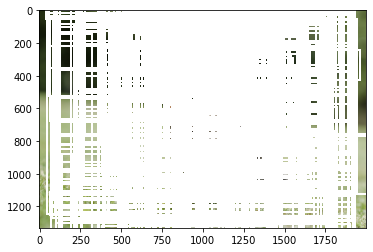

In [6]:
# Create plot
img = np.array(Image.open(input_img_filename))
plt.figure()
fig, ax = plt.subplots(1)
ax.imshow(img)

if detections is not None:
  detections_resized = rescale_boxes(detections[0], img_size, img.shape[:2])
  for detection in detections_resized[0:500]:  # just some of them
    x1, y1, x2, y2, conf = detection[0:5]
    # Create a Rectangle patch
    box_w = x2 - x1
    box_h = y2 - y1
    bbox = patches.Rectangle((x1, y1), box_w, box_h, linewidth=2, edgecolor="white", facecolor="none")
    # Add the bbox to the plot
    ax.add_patch(bbox)

**Using non-max suppresion**

In [9]:
# Object confidence threshold
conf_th = 0.05 #@param { type: "slider", min:0, max:1, step:0.05 }

# IoU thresshold for non-maximum suppression
iou_th = 0.85 #@param { type: "slider", min:0, max:1, step:0.05 }

input_img_filename = '../imgs/cat.jpg'
img = lycon.load(input_img_filename)

# Image preprocessing
h, w, _ = img.shape
img, pad = pad_to_square(img, 127.5)
padded_h, padded_w, _ = img.shape
# Resize to target shape
img = lycon.resize(img, height=img_size, width=img_size)
# Channels-first and normalize
img = torch.from_numpy(img).float().permute((2, 0, 1)) / 255.0

# Configure input image
img = img[None, :, :, :]  # create a batch of 1 image
img = Variable(img.type(Tensor))

# Get detections
with torch.no_grad():
    detections = model(img)
    detections_reduced = non_max_suppression(detections, conf_th, iou_th)
    print("Number of objects after non-max supression: " + str(len(detections_reduced)))

Number of objects after non-max supression: 1


**Visualize detections**

**Exercise: If multiple cats are detected change the non-max suppression parameters to fix that.**

tensor(800.9293)


<Figure size 432x288 with 0 Axes>

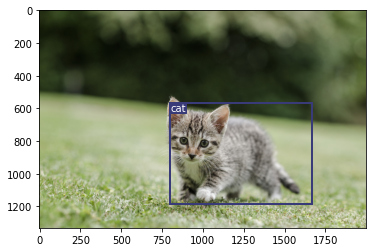

In [10]:
# Create plot
img = np.array(Image.open(input_img_filename))
plt.figure()
fig, ax = plt.subplots(1)
ax.imshow(img)

if detections_reduced is not None:
  # Random colors
  labels = [d[-1].item() for d in detections_reduced[0]]
  unique_labels = np.array(list(set(labels)))
  n_cls_preds = unique_labels.shape[0]
  import random
  cmap = plt.get_cmap("tab20b")
  colors = [cmap(i) for i in np.linspace(0, 1, len(detections_reduced))]
  bbox_colors = random.sample(colors, n_cls_preds)

  # Loop detections
  detections_reduced_resized = rescale_boxes(detections_reduced[0], img_size, img.shape[:2])
  for x1, y1, x2, y2, conf, cls_conf, cls_pred in detections_reduced_resized:
  # Create a Rectangle patch
    box_w = x2 - x1
    box_h = y2 - y1
    color = bbox_colors[int(np.where(unique_labels == int(cls_pred))[0])]
    bbox = patches.Rectangle((x1, y1), box_w, box_h, linewidth=2, edgecolor=color, facecolor="none")
    # Add the bbox to the plot
    ax.add_patch(bbox)
    print(x1)
    # Add label
    plt.text(x1, y1, s=classes[int(cls_pred)], color="white", verticalalignment="top", bbox={"color": color, "pad": 0},)